In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding,LSTM,Bidirectional,Dropout,GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\17573\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\17573\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\17573\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\17573\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Build a model model that predicts which Tweets are about real disasters and which one’s aren’t

# Data cleaning

In [2]:
df=pd.read_csv("train.csv")

In [3]:
df.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
np.array(df["text"])

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

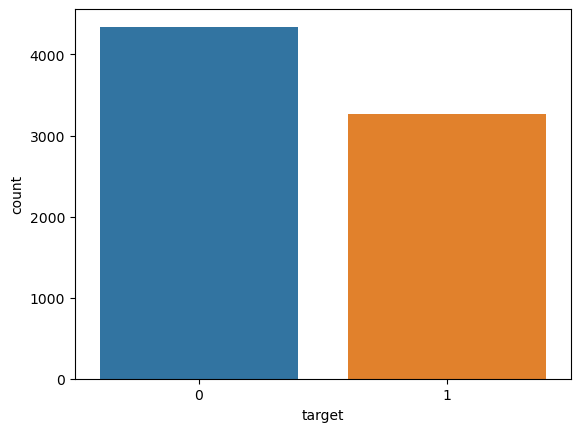

In [6]:
sns.countplot(x=df["target"])
#there is no big imbalance between two categories

In [7]:
df["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [8]:
def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stop words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    cleaned_text = ' '.join(tokens)  # Join tokens back into a string
    return cleaned_text

In [9]:
df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [10]:
df["text"]=df["text"].apply(clean_text)

In [11]:
df["text"][0]

'deed reason may allah forgive u'

In [12]:
X=df["text"]
y=df["target"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
#Tokenize the text by creating word_index dictionary
#tokenizer=Tokenizer(num_words=N_words,oov_token="<OOV>")  # OOV stands for out of vocabulary index(all uncommon words will be associated with index=1, index=0 is reserved for padding)
tokenizer=Tokenizer(oov_token="<OOV>")

In [15]:
#fit on your training corpus once and use that exact same word_index dictionary at
#train / eval / testing / prediction time to convert actual text into sequences to feed them to the network
tokenizer.fit_on_texts(X_train)

In [16]:
#print(tokenizer.word_index)

In [17]:
# Get the vocabulary length
N_words = len(tokenizer.word_index)+1
# we need vocabulary of size len(word_index) + 1 to be able to index up to the greatest token ID

In [18]:
N_words

9916

In [19]:
# Pad the sequences to a maximum length
padded_sequences = pad_sequences(sequences,padding='post', truncating='post')

NameError: name 'sequences' is not defined

In [ ]:
padded_sequences.shape

In [ ]:
max_seq_len=padded_sequences.shape[1]


In [ ]:
# Convert labels to numpy array
train_labels = np.array(y_train)

In [ ]:
labels=to_categorical(train_labels) #especially important for multiclass case

In [ ]:
#Get text sequences
sequences_test=tokenizer.texts_to_sequences(X_test)

In [ ]:
#padded test sequences
#set_max_len equal to the one from train sample
padded_sequences_test = pad_sequences(sequences_test,padding='post', truncating='post',maxlen=max_seq_len)#

In [ ]:
padded_sequences_test.shape

In [ ]:
type(padded_sequences_test)

In [ ]:
#test labels
test_labels=np.array(y_test)

In [ ]:
test_labels.shape

In [ ]:
labels_test=to_categorical(test_labels) 

# Deep Learning Model

In [ ]:
model = Sequential()
model.add(Embedding(N_words, 256, input_length=max_seq_len))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
early_stop=EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=0)#Track validation loss, try to minimize it, have little report , wait 25 epochs before stopping

In [ ]:
# Train the model
model.fit(
    padded_sequences,
    labels,
    epochs=10,
    batch_size=2,
#    validation_split=0.2,
    validation_data=(padded_sequences_test, labels_test),
    verbose=1,
    callbacks=[early_stop]
)

In [ ]:
losses_earlystop=pd.DataFrame(model.history.history)

In [ ]:
losses_earlystop.plot()

In [ ]:
results = model.evaluate(padded_sequences_test, labels_test)
print(results)

In [ ]:
test_predictions = model.predict(padded_sequences_test)

In [ ]:
test_clas1=test_predictions[:,1]

In [ ]:
test_prob_redictions = np.round(test_clas1)

In [ ]:
test_prob_redictions.shape

In [ ]:
test_prob_redictions.reshape(2513,)

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_labels,test_prob_redictions)

In [ ]:
print(classification_report(test_labels,test_prob_redictions))

In [ ]:
# Sample test review
sample_text = "We are evacuating because of tornado!"
sample_sequence = tokenizer.texts_to_sequences([sample_text])
sample_padded_sequence = pad_sequences(sample_sequence, maxlen=max_seq_len, padding='post', truncating='post')

In [ ]:
# Make prediction
prediction = model.predict(sample_padded_sequence)

In [ ]:
prediction

In [ ]:
print(f"Review: {sample_text}")
print(f"Predicted Sentiment: {'Positive' if prediction[:,1] > 0.5 else 'Negative'} (Score: {prediction[:,1]})")

In [ ]:
df_test=pd.read_csv("test.csv")

In [ ]:
df_test.head(20)

In [ ]:
df_test.info()

In [ ]:
test_sequence = tokenizer.texts_to_sequences(df_test["text"])
test_padded_sequence = pad_sequences(test_sequence, maxlen=max_seq_len, padding='post', truncating='post')

In [ ]:
#Prediction for two classes
test_pred= model.predict(test_padded_sequence)

In [ ]:
test_lab= np.round(test_pred[:,1]).astype(int)#To get prob for belongin to clas 1 actual disaster tweets

In [ ]:
df_sub=pd.DataFrame(data=df_test["id"],columns=["id"])

In [ ]:
df_sub["target"]=test_lab

In [ ]:
df_sub.to_csv("Test_results.csv",index=False)


# Machine learning models

In [721]:
#transform test data to prepare for model
vec=TfidfVectorizer()
vec.fit(X_train)

TfidfVectorizer()

In [722]:
X_train_tfidf=vec.transform(X_train)

In [723]:
X_test_tfidf=vec.transform(X_test)

In [724]:
def label_classify(model,param_grid,X_train_tfidf,y_train, X_test_tfidf,y_test):

    grid=GridSearchCV(model,param_grid)
    grid.fit(X_train_tfidf,y_train)
    y_pred=grid.predict(X_test_tfidf)
    mod_eval = accuracy_score(y_test,y_pred)

    print(f"Model accuracy is : {mod_eval}")
    print(f"Best parameters are: {grid.best_params_}")
    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Model accuracy is : 0.8010346199761241
Best parameters are: {'max_iter': 100}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1446
           1       0.83      0.67      0.74      1067

    accuracy                           0.80      2513
   macro avg       0.81      0.78      0.79      2513
weighted avg       0.80      0.80      0.80      2513



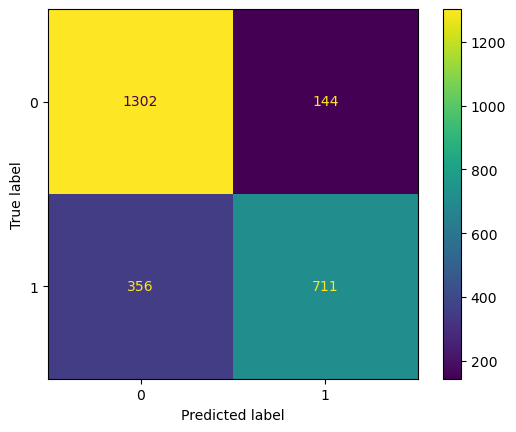

In [725]:
log_model=LogisticRegression()
param_grid={"max_iter":[100,500,1000, 2000]}
label_classify(log_model,param_grid,X_train_tfidf,y_train,X_test_tfidf,y_test)

Model accuracy is : 0.7954635893354556
Best parameters are: {'alpha': 1}
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1446
           1       0.83      0.65      0.73      1067

    accuracy                           0.80      2513
   macro avg       0.80      0.78      0.78      2513
weighted avg       0.80      0.80      0.79      2513



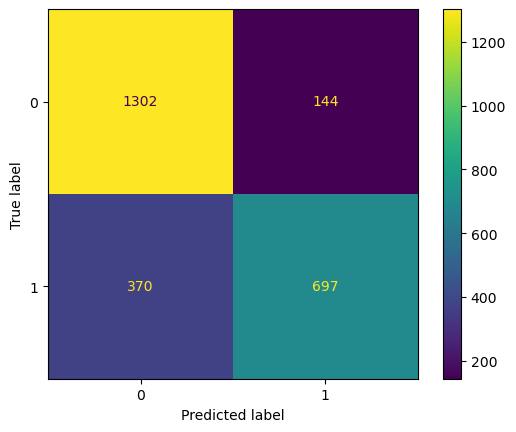

In [726]:
nb=MultinomialNB()
param_grid={"alpha":[1,0.8]}
label_classify(nb,param_grid,X_train_tfidf,y_train,X_test_tfidf,y_test)

In [ ]:
#Overall we see similar performance from deep lerning and machine learnin models